<a href="https://colab.research.google.com/github/atlantiquesun/Stock_ML/blob/main/stock_all_models_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf


# 1. Preprocessing

In [7]:
def make_multistep_dataset(df, features_column, steps=1):
  
  for i in range(steps):
    for feature in features_column:
      df[feature+"(t-"+str(i+1)+")"] = df[feature+"(t)"].shift(i+1)
  
  df = df.dropna()
  return df


def get_file_index(file_name):

    index = file_name.split(".")[0]
    start = 0
    while (start < len(index) and index[start] == "0"):
      start += 1
    return int(index[start:])


def load_data(data_folder, n_stocks, columns, steps):

  files = os.listdir(data_folder)
  files.sort(key = lambda x: get_file_index(x))

  df = None
  for i in range(n_stocks):
    
    # get file name
    file = files[i]

    # load data
    df_temp = pd.read_csv(data_folder+"/"+file, names=columns)

    # add percentage return (close(t) - close(t-1))/close(t)
    df_temp['percentage_return(t)'] = (df_temp['close(t)'] - df_temp['close(t)'].shift(1))/df_temp['close(t)']

    # make multistep dataset
    features_column = [x[:-3] for x in columns]
    df_temp = make_multistep_dataset(df_temp, features_column, steps)
    df_temp = df_temp.dropna()
    df_temp['time_index'] = df_temp.index #keep the original timestep index of each record
    df_temp['ticker'] = file.split('.')[0] #get the ticker number

    # concatenate with df
    if (i==0):
      df = df_temp
    else:
      df = pd.concat([df, df_temp])

    # make sure the index is correct
    df = df.reset_index(drop = True)
  
  return df


class min_max_scaler: # scale for each ticker

  def __init__(self):

    self.scaler = None
  
  def fit(self, df, fit_columns):
    
    if ('ticker' not in df.columns):
      raise ValueError("df does not have the column 'ticker.'")
    
    # clear self.scaler
    self.scaler = pd.DataFrame(columns=["ticker", "min", "max"])
    
    tickers = list(set(list(df['ticker'])))
    tickers.sort(key = lambda x: get_file_index(x))
    self.scaler.ticker = tickers
    self.scaler = self.scaler.set_index('ticker', drop=True)

    for ticker in tickers:
      # choose the ticker then choose the columns
      df_ticker = df.loc[df.ticker == ticker][fit_columns] 
      # get the min and the max for the ticker
      self.scaler.at[ticker, 'min_val'] = df_ticker.values.min()
      self.scaler.at[ticker, 'max_val'] = df_ticker.values.max()
  
  def transform(self, df, transform_columns):

    if (self.scaler is None):
      raise ValueError("The scaler has not been fitted.")
    if ('ticker' not in df.columns):
      raise ValueError("df does not have the column 'ticker.'")

    # generate a scale for the current df
    min_map = dict(zip(list(self.scaler.index), list(self.scaler.min_val)))
    max_map = dict(zip(list(self.scaler.index), list(self.scaler.max_val)))
    min_scale = df['ticker'].map(min_map)
    max_scale = df['ticker'].map(max_map)

    # transform each column
    for column in transform_columns:
      df[column] = (df[column].values - min_scale)/(max_scale - min_scale)
    
    return df
  
  def fit_transform(self, df, fit_columns, transform_columns):

    self.fit(df, fit_columns)
    return self.transform(df, transform_columns)
  
  def inverse_transform(self, df, transform_columns):

    if (self.scaler is None):
      raise ValueError("The scaler has not been fitted.")
    if ('ticker' not in df.columns):
      raise ValueError("df does not have the column 'ticker.'")
    
    # generate a scale for the current df
    min_map = dict(zip(list(self.scaler.index), list(self.scaler.min_val)))
    max_map = dict(zip(list(self.scaler.index), list(self.scaler.max_val)))
    min_scale = df['ticker'].map(min_map)
    max_scale = df['ticker'].map(max_map)

    # inverse transform each column
    for column in transform_columns:
      df[column] = (df[column].values * (max_scale - min_scale)) + min_scale
    
    return df




In [8]:
def prepare_train_data(df, features_column, target_column, steps, start=0, train_window=72, delta=1):
  '''
  'features_column' here is not necessarily the same as 'features_column' in make_multistep_dataset() and is a list
  'target_column' is a string, e.g. "open"
  '''

  df = df.loc[(df.time_index >= start) & (df.time_index < start+train_window)]

  train_columns = []
  for i in range(1, steps+1):
      train_columns.extend([x+"(t-"+str(i)+")" for x in features_column])
  
  # fit transform the data
  scaler = min_max_scaler()
  transform_columns = train_columns + [target_column+"(t)"]
  df = scaler.fit_transform(df, train_columns, transform_columns)

  X_train = df[train_columns].values
  # nonlinear transform to prevent lagged prediction
  # add delta to prevent 0
  X_train = np.sqrt(X_train + delta) 
  X_train_lstm = np.reshape(X_train, (X_train.shape[0], steps, len(features_column))) #lstm data shape: (samples, timesteps, features)
  y_train = df[target_column+"(t)"].values

  print(X_train.shape, X_train_lstm.shape, y_train.shape)
  return (X_train, X_train_lstm, y_train, scaler) #scaler is to be used on the test set


def prepare_test_data(df, features_column, target_column, steps, scaler, start=0, train_window=72, delta=1):
  '''
  'features_column' here is not necessarily the same as 'features_column' in make_multistep_dataset() and is a list
  'target_column' is a string, e.g. "open"
  '''

  df = df.loc[(df.time_index >= start) & (df.time_index < start+train_window)]

  #select the features
  train_columns = []
  for i in range(1, steps+1):
      train_columns.extend([x+"(t-"+str(i)+")" for x in features_column])
  
  # transform the data
  transform_columns = train_columns + [target_column+"(t)"]
  df = scaler.transform(df, transform_columns)
  
  X_train = df[train_columns].values
  # nonlinear transform to prevent lagged prediction
  # add delta to prevent 0
  X_train = np.sqrt(X_train + delta) 
  X_train_lstm = np.reshape(X_train, (X_train.shape[0], steps, len(features_column))) #lstm data shape: (samples, timesteps, features)
  y_train = df[target_column+"(t)"].values
  trade_tic = df['ticker']

  print(X_train.shape, X_train_lstm.shape, y_train.shape)
  return (X_train, X_train_lstm, y_train, trade_tic)


# 2. Models

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import SGD

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor



def train_lstm(X_train, y_train, epochs=50, batch_size=64):

  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation="tanh"))
    model.add(Dense(1))

    model.compile(loss='mae', optimizer="adam")
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)
    return model


def train_lr(X_train, y_train):
  
  lr_regressor = LinearRegression()
  model = lr_regressor.fit(X_train, y_train)

  return model


def train_lasso(X_train, y_train):

  lasso_regressor = Lasso(alpha=0.001)
  model = lasso_regressor.fit(X_train, y_train)
  return model


def train_ridge(X_train, y_train):

  ridge_regressor = Ridge(alpha=0.0001)
  model = ridge_regressor.fit(X_train, y_train)

  return model


def train_svm(X_train, y_train):
  with tf.device('/device:GPU:0'):
    svr = SVR(C=1.0, kernel='rbf', gamma=0.1)
    model = svr.fit(X_train, y_train)
    return model


def train_gbm(X_train, y_train):
  with tf.device('/device:GPU:0'):
    gbr = GradientBoostingRegressor(loss='lad', learning_rate=0.1, n_estimators=50, max_depth=5)
    model = gbr.fit(X_train, y_train)
    return model


def train_ada(X_train, y_train):
  with tf.device('/device:GPU:0'):
    base_estimator = DecisionTreeRegressor(max_depth=5)
    ada = AdaBoostRegressor(base_estimator=base_estimator, n_estimators=50, learning_rate=0.01, loss='linear')
    model = ada.fit(X_train, y_train)
    return model


#model evaluation
def evaluate_model(model, X_test, y_test):
    from sklearn.metrics import mean_squared_error
    #from sklearn.metrics import mean_squared_log_error

    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import r2_score
    y_predict = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_predict)
    

    mse = mean_squared_error(y_test, y_predict)
    #msle = mean_squared_log_error(y_test, y_predict)

    explained_variance = explained_variance_score(y_test, y_predict)
    r2 = r2_score(y_test, y_predict)

    return mae

# 3. Training (Multiple Stocks Rolling Window)

In [10]:
# prepare data
columns = ["open(t)", "close(t)", "high(t)", "low(t)"]
steps = 20 # include 20 timestamps for each sample
data_folder = "/content/drive/MyDrive/StockML /processed_data"
n_stocks = 500 # use 500 stocks
df = load_data(data_folder, n_stocks, columns, steps)
display(df)

,open(t),close(t),high(t),low(t),percentage_return(t),open(t-1),close(t-1),high(t-1),low(t-1),open(t-2),close(t-2),high(t-2),low(t-2),open(t-3),close(t-3),high(t-3),low(t-3),open(t-4),close(t-4),high(t-4),low(t-4),open(t-5),close(t-5),high(t-5),low(t-5),open(t-6),close(t-6),high(t-6),low(t-6),open(t-7),close(t-7),high(t-7),low(t-7),open(t-8),close(t-8),high(t-8),low(t-8),open(t-9),close(t-9),high(t-9),...,high(t-11),low(t-11),open(t-12),close(t-12),high(t-12),low(t-12),open(t-13),close(t-13),high(t-13),low(t-13),open(t-14),close(t-14),high(t-14),low(t-14),open(t-15),close(t-15),high(t-15),low(t-15),open(t-16),close(t-16),high(t-16),low(t-16),open(t-17),close(t-17),high(t-17),low(t-17),open(t-18),close(t-18),high(t-18),low(t-18),open(t-19),close(t-19),high(t-19),low(t-19),open(t-20),close(t-20),high(t-20),low(t-20),time_index,ticker
0,21.37,21.28,21.51,21.01,0.003289,21.43,21.21,21.79,21.04,22.23,21.92,22.38,21.51,22.10,21.99,22.11,21.39,22.21,21.76,22.50,21.65,23.61,22.21,23.61,22.09,23.77,23.66,24.00,23.39,23.81,24.11,24.36,23.30,24.41,23.63,24.77,23.20,24.60,24.39,24.65,...,25.11,24.08,23.99,24.41,25.04,23.85,23.30,24.76,24.98,23.20,23.20,23.10,23.91,22.73,22.82,24.36,24.80,22.52,22.63,22.91,23.36,22.53,22.60,22.63,23.00,22.27,22.14,22.90,23.29,22.14,22.13,22.20,23.14,22.13,21.55,22.31,22.42,21.26,20,000001
1,21.45,21.48,21.98,21.09,0.009311,21.37,21.28,21.51,21.01,21.43,21.21,21.79,21.04,22.23,21.92,22.38,21.51,22.10,21.99,22.11,21.39,22.21,21.76,22.50,21.65,23.61,22.21,23.61,22.09,23.77,23.66,24.00,23.39,23.81,24.11,24.36,23.30,24.41,23.63,24.77,...,24.71,23.91,24.41,24.74,25.11,24.08,23.99,24.41,25.04,23.85,23.30,24.76,24.98,23.20,23.20,23.10,23.91,22.73,22.82,24.36,24.80,22.52,22.63,22.91,23.36,22.53,22.60,22.63,23.00,22.27,22.14,22.90,23.29,22.14,22.13,22.20,23.14,22.13,21,000001
2,21.41,22.83,22.90,21.29,0.059133,21.45,21.48,21.98,21.09,21.37,21.28,21.51,21.01,21.43,21.21,21.79,21.04,22.23,21.92,22.38,21.51,22.10,21.99,22.11,21.39,22.21,21.76,22.50,21.65,23.61,22.21,23.61,22.09,23.77,23.66,24.00,23.39,23.81,24.11,24.36,...,24.65,23.98,24.71,24.61,24.71,23.91,24.41,24.74,25.11,24.08,23.99,24.41,25.04,23.85,23.30,24.76,24.98,23.20,23.20,23.10,23.91,22.73,22.82,24.36,24.80,22.52,22.63,22.91,23.36,22.53,22.60,22.63,23.00,22.27,22.14,22.90,23.29,22.14,22,000001
3,22.59,22.74,23.31,22.47,-0.003958,21.41,22.83,22.90,21.29,21.45,21.48,21.98,21.09,21.37,21.28,21.51,21.01,21.43,21.21,21.79,21.04,22.23,21.92,22.38,21.51,22.10,21.99,22.11,21.39,22.21,21.76,22.50,21.65,23.61,22.21,23.61,22.09,23.77,23.66,24.00,...,24.77,23.20,24.60,24.39,24.65,23.98,24.71,24.61,24.71,23.91,24.41,24.74,25.11,24.08,23.99,24.41,25.04,23.85,23.30,24.76,24.98,23.20,23.20,23.10,23.91,22.73,22.82,24.36,24.80,22.52,22.63,22.91,23.36,22.53,22.60,22.63,23.00,22.27,23,000001
4,22.52,22.17,22.80,21.69,-0.025710,22.59,22.74,23.31,22.47,21.41,22.83,22.90,21.29,21.45,21.48,21.98,21.09,21.37,21.28,21.51,21.01,21.43,21.21,21.79,21.04,22.23,21.92,22.38,21.51,22.10,21.99,22.11,21.39,22.21,21.76,22.50,21.65,23.61,22.21,23.61,...,24.36,23.30,24.41,23.63,24.77,23.20,24.60,24.39,24.65,23.98,24.71,24.61,24.71,23.91,24.41,24.74,25.11,24.08,23.99,24.41,25.04,23.85,23.30,24.76,24.98,23.20,23.20,23.10,23.91,22.73,22.82,24.36,24.80,22.52,22.63,22.91,23.36,22.53,24,000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,423.24,402.60,429.64,389.65,-0.073025,389.88,432.00,432.00,386.08,379.95,393.96,400.01,365.50,364.00,372.88,374.16,337.03,371.99,373.00,405.02,362.00,369.47,368.55,380.74,353.01,375.00,373.38,384.66,367.38,350.00,375.18,380.88,335.50,322.32,346.25,346.25,318.65,318.15,314.77,326.33,...,351.00,320.00,313.00,332.00,335.00,310.74,319.89,316.63,328.88,314.00,330.00,323.33,333.91,310.00,

In [ ]:
# training set up 
features_column = ["open", "close", "high", "low"] 
target_column = "close"
steps = 20 #use 20 timesteps for each training sample
n_windows = 40 #20 (train, test, trade) triples in total
train_start = steps
train_starts = list(range(train_start, train_start+n_windows))
train_window = 48
test_starts = list(range(train_start+train_window, train_start+train_window+n_windows))
test_window = 12
trade_starts = list(range(train_start+train_window+test_window, train_start+train_window+test_window+n_windows))
trade_window = 1
lstm_epochs = 40 

unique_ticker = list(set(list(df['ticker'])))
unique_ticker.sort(key = lambda x: get_file_index(x))
unique_datetime = trade_starts
df_predict_lr = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_lasso = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_ridge = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_svm= pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_gbm = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_ada = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_lstm = pd.DataFrame(columns=unique_ticker, index=unique_datetime)

df_predict_best = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_best_model_name = pd.DataFrame(columns=['model_name'], index=unique_datetime)
df_actual = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
evaluation_record = []
scalers = {}


for i in range(n_windows):

  # get start dates
  train_start = train_starts[i]
  test_start = test_starts[i]
  trade_start = trade_starts[i]

  # prepare datasets
  X_train, X_train_lstm, y_train, scaler = prepare_train_data(df, features_column, target_column, steps, train_start, train_window)
  X_test, X_test_lstm, y_test, _ = prepare_test_data(df, features_column, target_column, steps, scaler, test_start, test_window)
  X_trade, X_trade_lstm, y_trade, trade_tic = prepare_test_data(df, features_column, target_column, steps, scaler, trade_start, trade_window)
  scalers[trade_start] = scaler

  # train 
  lr_model = train_lr(X_train, y_train)
  lasso_model = train_lasso(X_train, y_train)
  ridge_model = train_ridge(X_train, y_train)
  svm_model = train_svm(X_train, y_train)
  gbm_model = train_gbm(X_train, y_train)
  ada_model = train_ada(X_train, y_train)
  lstm_model = train_lstm(X_train_lstm, y_train, lstm_epochs)

  # validate
  lr_eval = evaluate_model(lr_model, X_test, y_test)
  lasso_eval = evaluate_model(lasso_model, X_test, y_test)
  ridge_eval = evaluate_model(ridge_model, X_test, y_test)
  svm_eval = evaluate_model(svm_model, X_test, y_test)
  gbm_eval = evaluate_model(gbm_model, X_test, y_test)
  ada_eval = evaluate_model(ada_model, X_test, y_test)
  lstm_eval = evaluate_model(lstm_model, X_test_lstm, y_test)

  # trade
  y_trade_lr = lr_model.predict(X_trade)
  y_trade_lasso = lasso_model.predict(X_trade)
  y_trade_ridge = ridge_model.predict(X_trade)
  y_trade_svm = svm_model.predict(X_trade)
  y_trade_gbm = gbm_model.predict(X_trade)
  y_trade_ada = ada_model.predict(X_trade)
  y_trade_lstm = lstm_model.predict(X_trade_lstm).flatten()

  eval_data = [[lr_eval, y_trade_lr], 
                    [lasso_eval, y_trade_lasso],
                    [ridge_eval, y_trade_ridge],
                    [svm_eval,y_trade_svm],
                    [gbm_eval,y_trade_gbm],                     
                    [ada_eval,y_trade_ada],
                    [lstm_eval,y_trade_lstm]
                    ]

  eval_table = pd.DataFrame(eval_data, columns=['model_eval', 'model_predict_close'],
                                  index=['lr', 'lasso','ridge', 'svm', 'gbm', 'ada', 'lstm'])   
  evaluation_record.append((trade_start, eval_table))

  # lowest error score model
  y_trade_best = eval_table.model_predict_close.values[eval_table.model_eval == eval_table.model_eval.min()][0]
  best_model_name = eval_table.index.values[eval_table.model_eval == eval_table.model_eval.min()][0]
  df_best_model_name.loc[trade_start] = best_model_name

  # prepare predicted close price table
  assert list(trade_tic)==unique_ticker # ensure that the row is filled in correctly
  df_predict_lr.loc[trade_start] = y_trade_lr
  df_predict_lasso.loc[trade_start] = y_trade_lasso
  df_predict_ridge.loc[trade_start] = y_trade_ridge
  df_predict_svm.loc[trade_start] = y_trade_svm
  df_predict_gbm.loc[trade_start] = y_trade_gbm
  df_predict_ada.loc[trade_start] = y_trade_ada
  df_predict_lstm.loc[trade_start] = y_trade_lstm
  df_predict_best.loc[trade_start] = y_trade_best
  print(y_trade_lr)
  print(y_trade_lstm)

  # fill in the actual close price
  df_actual.loc[trade_start] = y_trade

  print("Trade date:", trade_start)


# save the raw results
df_predict_lr.to_csv("/content/drive/MyDrive/StockML /lr.csv")
df_predict_lasso.to_csv("/content/drive/MyDrive/StockML /lasso.csv")
df_predict_ridge.to_csv("/content/drive/MyDrive/StockML /ridge.csv")
df_predict_svm.to_csv("/content/drive/MyDrive/StockML /svm.csv")
df_predict_gbm.to_csv("/content/drive/MyDrive/StockML /gbm.csv")
df_predict_ada.to_csv("/content/drive/MyDrive/StockML /ada.csv")
df_predict_lstm.to_csv("/content/drive/MyDrive/StockML /lstm.csv")
df_predict_best.to_csv("/content/drive/MyDrive/StockML /best.csv")
df_actual.to_csv("/content/drive/MyDrive/StockML /actual.csv")
df_best_model_name.to_csv("/content/drive/MyDrive/StockML /best_model_name.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 4s - loss: 0.1922
Epoch 2/40
375/375 - 2s - loss: 0.1818
Epoch 3/40
375/375 - 2s - loss: 0.1802
Epoch 4/40
375/375 - 2s - loss: 0.1791
Epoch 5/40
375/375 - 2s - loss: 0.1714
Epoch 6/40
375/375 - 2s - loss: 0.1225
Epoch 7/40
375/375 - 2s - loss: 0.1132
Epoch 8/40
375/375 - 2s - loss: 0.1053
Epoch 9/40
375/375 - 2s - loss: 0.1017
Epoch 10/40
375/375 - 2s - loss: 0.0996
Epoch 11/40
375/375 - 2s - loss: 0.0931
Epoch 12/40
375/375 - 2s - loss: 0.0910
Epoch 13/40
375/375 - 2s - loss: 0.0862
Epoch 14/40
375/375 - 2s - loss: 0.0829
Epoch 15/40
375/375 - 2s - loss: 0.0828
Epoch 16/40
375/375 - 2s - loss: 0.0812
Epoch 17/40
375/375 - 2s - loss: 0.0795
Epoch 18/40
375/375 - 2s - loss: 0.0779
Epoch 19/40
375/375 - 2s - loss: 0.0781
Epoch 20/40
375/375 - 2s - loss: 0.0765
Epoch 21/40
375/375 - 2s - loss: 0.0759
Epoch 22/40
375/375 - 2s - loss: 0.0753
Epoch 23/40
375/375 - 2s - loss: 0.0762
Epoch 24/40
375/375 - 2s - loss: 0.0745
Epoch 25/40
375/375 - 2s - loss: 0.0742
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2080
Epoch 2/40
375/375 - 2s - loss: 0.1843
Epoch 3/40
375/375 - 2s - loss: 0.1818
Epoch 4/40
375/375 - 2s - loss: 0.1808
Epoch 5/40
375/375 - 2s - loss: 0.1802
Epoch 6/40
375/375 - 2s - loss: 0.1761
Epoch 7/40
375/375 - 2s - loss: 0.1317
Epoch 8/40
375/375 - 2s - loss: 0.1170
Epoch 9/40
375/375 - 2s - loss: 0.1091
Epoch 10/40
375/375 - 2s - loss: 0.0998
Epoch 11/40
375/375 - 2s - loss: 0.0926
Epoch 12/40
375/375 - 2s - loss: 0.0883
Epoch 13/40
375/375 - 2s - loss: 0.0856
Epoch 14/40
375/375 - 2s - loss: 0.0855
Epoch 15/40
375/375 - 2s - loss: 0.0812
Epoch 16/40
375/375 - 2s - loss: 0.0805
Epoch 17/40
375/375 - 2s - loss: 0.0789
Epoch 18/40
375/375 - 2s - loss: 0.0763
Epoch 19/40
375/375 - 2s - loss: 0.0743
Epoch 20/40
375/375 - 2s - loss: 0.0753
Epoch 21/40
375/375 - 2s - loss: 0.0759
Epoch 22/40
375/375 - 2s - loss: 0.0779
Epoch 23/40
375/375 - 2s - loss: 0.0723
Epoch 24/40
375/375 - 2s - loss: 0.0728
Epoch 25/40
375/375 - 2s - loss: 0.0707
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2042
Epoch 2/40
375/375 - 2s - loss: 0.1837
Epoch 3/40
375/375 - 2s - loss: 0.1815
Epoch 4/40
375/375 - 2s - loss: 0.1729
Epoch 5/40
375/375 - 2s - loss: 0.1299
Epoch 6/40
375/375 - 2s - loss: 0.1209
Epoch 7/40
375/375 - 2s - loss: 0.1127
Epoch 8/40
375/375 - 2s - loss: 0.1086
Epoch 9/40
375/375 - 2s - loss: 0.0998
Epoch 10/40
375/375 - 2s - loss: 0.0951
Epoch 11/40
375/375 - 2s - loss: 0.0921
Epoch 12/40
375/375 - 2s - loss: 0.0872
Epoch 13/40
375/375 - 2s - loss: 0.0871
Epoch 14/40
375/375 - 2s - loss: 0.0833
Epoch 15/40
375/375 - 2s - loss: 0.0797
Epoch 16/40
375/375 - 2s - loss: 0.0798
Epoch 17/40
375/375 - 2s - loss: 0.0759
Epoch 18/40
375/375 - 2s - loss: 0.0765
Epoch 19/40
375/375 - 2s - loss: 0.0760
Epoch 20/40
375/375 - 2s - loss: 0.0754
Epoch 21/40
375/375 - 2s - loss: 0.0746
Epoch 22/40
375/375 - 2s - loss: 0.0738
Epoch 23/40
375/375 - 2s - loss: 0.0712
Epoch 24/40
375/375 - 2s - loss: 0.0714
Epoch 25/40
375/375 - 2s - loss: 0.0713
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 4s - loss: 0.2093
Epoch 2/40
375/375 - 2s - loss: 0.1833
Epoch 3/40
375/375 - 2s - loss: 0.1805
Epoch 4/40
375/375 - 2s - loss: 0.1673
Epoch 5/40
375/375 - 2s - loss: 0.1308
Epoch 6/40
375/375 - 2s - loss: 0.1162
Epoch 7/40
375/375 - 2s - loss: 0.1124
Epoch 8/40
375/375 - 2s - loss: 0.1069
Epoch 9/40
375/375 - 2s - loss: 0.1012
Epoch 10/40
375/375 - 2s - loss: 0.0982
Epoch 11/40
375/375 - 2s - loss: 0.0933
Epoch 12/40
375/375 - 2s - loss: 0.0912
Epoch 13/40
375/375 - 2s - loss: 0.0883
Epoch 14/40
375/375 - 2s - loss: 0.0856
Epoch 15/40
375/375 - 2s - loss: 0.0850
Epoch 16/40
375/375 - 2s - loss: 0.0821
Epoch 17/40
375/375 - 2s - loss: 0.0799
Epoch 18/40
375/375 - 2s - loss: 0.0813
Epoch 19/40
375/375 - 2s - loss: 0.0778
Epoch 20/40
375/375 - 2s - loss: 0.0787
Epoch 21/40
375/375 - 2s - loss: 0.0757
Epoch 22/40
375/375 - 2s - loss: 0.0753
Epoch 23/40
375/375 - 2s - loss: 0.0738
Epoch 24/40
375/375 - 2s - loss: 0.0735
Epoch 25/40
375/375 - 2s - loss: 0.0741
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2035
Epoch 2/40
375/375 - 2s - loss: 0.1832
Epoch 3/40
375/375 - 2s - loss: 0.1811
Epoch 4/40
375/375 - 2s - loss: 0.1691
Epoch 5/40
375/375 - 2s - loss: 0.1209
Epoch 6/40
375/375 - 2s - loss: 0.1112
Epoch 7/40
375/375 - 2s - loss: 0.1045
Epoch 8/40
375/375 - 2s - loss: 0.1003
Epoch 9/40
375/375 - 2s - loss: 0.0963
Epoch 10/40
375/375 - 2s - loss: 0.0913
Epoch 11/40
375/375 - 2s - loss: 0.0877
Epoch 12/40
375/375 - 2s - loss: 0.0853
Epoch 13/40
375/375 - 2s - loss: 0.0811
Epoch 14/40
375/375 - 2s - loss: 0.0811
Epoch 15/40
375/375 - 2s - loss: 0.0820
Epoch 16/40
375/375 - 2s - loss: 0.0790
Epoch 17/40
375/375 - 2s - loss: 0.0783
Epoch 18/40
375/375 - 2s - loss: 0.0764
Epoch 19/40
375/375 - 2s - loss: 0.0774
Epoch 20/40
375/375 - 2s - loss: 0.0752
Epoch 21/40
375/375 - 2s - loss: 0.0767
Epoch 22/40
375/375 - 2s - loss: 0.0749
Epoch 23/40
375/375 - 2s - loss: 0.0735
Epoch 24/40
375/375 - 2s - loss: 0.0739
Epoch 25/40
375/375 - 2s - loss: 0.0745
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.1916
Epoch 2/40
375/375 - 2s - loss: 0.1835
Epoch 3/40
375/375 - 2s - loss: 0.1548
Epoch 4/40
375/375 - 2s - loss: 0.1201
Epoch 5/40
375/375 - 2s - loss: 0.1096
Epoch 6/40
375/375 - 2s - loss: 0.1052
Epoch 7/40
375/375 - 2s - loss: 0.0980
Epoch 8/40
375/375 - 2s - loss: 0.0943
Epoch 9/40
375/375 - 2s - loss: 0.0933
Epoch 10/40
375/375 - 2s - loss: 0.0899
Epoch 11/40
375/375 - 2s - loss: 0.0880
Epoch 12/40
375/375 - 2s - loss: 0.0847
Epoch 13/40
375/375 - 2s - loss: 0.0857
Epoch 14/40
375/375 - 2s - loss: 0.0832
Epoch 15/40
375/375 - 2s - loss: 0.0820
Epoch 16/40
375/375 - 2s - loss: 0.0791
Epoch 17/40
375/375 - 2s - loss: 0.0791
Epoch 18/40
375/375 - 2s - loss: 0.0766
Epoch 19/40
375/375 - 2s - loss: 0.0781
Epoch 20/40
375/375 - 2s - loss: 0.0741
Epoch 21/40
375/375 - 2s - loss: 0.0743
Epoch 22/40
375/375 - 2s - loss: 0.0750
Epoch 23/40
375/375 - 2s - loss: 0.0738
Epoch 24/40
375/375 - 2s - loss: 0.0725
Epoch 25/40
375/375 - 2s - loss: 0.0729
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 4s - loss: 0.1973
Epoch 2/40
375/375 - 2s - loss: 0.1861
Epoch 3/40
375/375 - 2s - loss: 0.1839
Epoch 4/40
375/375 - 2s - loss: 0.1654
Epoch 5/40
375/375 - 2s - loss: 0.1344
Epoch 6/40
375/375 - 2s - loss: 0.1212
Epoch 7/40
375/375 - 2s - loss: 0.1108
Epoch 8/40
375/375 - 2s - loss: 0.1035
Epoch 9/40
375/375 - 2s - loss: 0.0979
Epoch 10/40
375/375 - 2s - loss: 0.0949
Epoch 11/40
375/375 - 2s - loss: 0.0922
Epoch 12/40
375/375 - 2s - loss: 0.0884
Epoch 13/40
375/375 - 2s - loss: 0.0889
Epoch 14/40
375/375 - 2s - loss: 0.0848
Epoch 15/40
375/375 - 2s - loss: 0.0818
Epoch 16/40
375/375 - 2s - loss: 0.0805
Epoch 17/40
375/375 - 2s - loss: 0.0803
Epoch 18/40
375/375 - 2s - loss: 0.0802
Epoch 19/40
375/375 - 2s - loss: 0.0757
Epoch 20/40
375/375 - 2s - loss: 0.0757
Epoch 21/40
375/375 - 2s - loss: 0.0762
Epoch 22/40
375/375 - 2s - loss: 0.0723
Epoch 23/40
375/375 - 2s - loss: 0.0724
Epoch 24/40
375/375 - 2s - loss: 0.0716
Epoch 25/40
375/375 - 2s - loss: 0.0722
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2045
Epoch 2/40
375/375 - 2s - loss: 0.1878
Epoch 3/40
375/375 - 2s - loss: 0.1852
Epoch 4/40
375/375 - 2s - loss: 0.1615
Epoch 5/40
375/375 - 2s - loss: 0.1252
Epoch 6/40
375/375 - 2s - loss: 0.1118
Epoch 7/40
375/375 - 2s - loss: 0.1054
Epoch 8/40
375/375 - 2s - loss: 0.1007
Epoch 9/40
375/375 - 2s - loss: 0.0990
Epoch 10/40
375/375 - 2s - loss: 0.0922
Epoch 11/40
375/375 - 2s - loss: 0.0891
Epoch 12/40
375/375 - 2s - loss: 0.0863
Epoch 13/40
375/375 - 2s - loss: 0.0852
Epoch 14/40
375/375 - 2s - loss: 0.0813
Epoch 15/40
375/375 - 2s - loss: 0.0807
Epoch 16/40
375/375 - 2s - loss: 0.0792
Epoch 17/40
375/375 - 2s - loss: 0.0776
Epoch 18/40
375/375 - 2s - loss: 0.0771
Epoch 19/40
375/375 - 2s - loss: 0.0760
Epoch 20/40
375/375 - 2s - loss: 0.0731
Epoch 21/40
375/375 - 2s - loss: 0.0736
Epoch 22/40
375/375 - 2s - loss: 0.0746
Epoch 23/40
375/375 - 2s - loss: 0.0716
Epoch 24/40
375/375 - 2s - loss: 0.0711
Epoch 25/40
375/375 - 2s - loss: 0.0729
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2064
Epoch 2/40
375/375 - 2s - loss: 0.1873
Epoch 3/40
375/375 - 2s - loss: 0.1837
Epoch 4/40
375/375 - 2s - loss: 0.1353
Epoch 5/40
375/375 - 2s - loss: 0.1108
Epoch 6/40
375/375 - 2s - loss: 0.1062
Epoch 7/40
375/375 - 2s - loss: 0.1011
Epoch 8/40
375/375 - 2s - loss: 0.0979
Epoch 9/40
375/375 - 2s - loss: 0.0930
Epoch 10/40
375/375 - 2s - loss: 0.0893
Epoch 11/40
375/375 - 2s - loss: 0.0854
Epoch 12/40
375/375 - 2s - loss: 0.0825
Epoch 13/40
375/375 - 2s - loss: 0.0812
Epoch 14/40
375/375 - 2s - loss: 0.0788
Epoch 15/40
375/375 - 2s - loss: 0.0774
Epoch 16/40
375/375 - 2s - loss: 0.0760
Epoch 17/40
375/375 - 2s - loss: 0.0745
Epoch 18/40
375/375 - 2s - loss: 0.0747
Epoch 19/40
375/375 - 2s - loss: 0.0743
Epoch 20/40
375/375 - 2s - loss: 0.0744
Epoch 21/40
375/375 - 2s - loss: 0.0739
Epoch 22/40
375/375 - 2s - loss: 0.0723
Epoch 23/40
375/375 - 2s - loss: 0.0751
Epoch 24/40
375/375 - 2s - loss: 0.0738
Epoch 25/40
375/375 - 2s - loss: 0.0708
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2021
Epoch 2/40
375/375 - 2s - loss: 0.1857
Epoch 3/40
375/375 - 2s - loss: 0.1372
Epoch 4/40
375/375 - 2s - loss: 0.1133
Epoch 5/40
375/375 - 2s - loss: 0.1055
Epoch 6/40
375/375 - 2s - loss: 0.1023
Epoch 7/40
375/375 - 2s - loss: 0.0963
Epoch 8/40
375/375 - 2s - loss: 0.0927
Epoch 9/40
375/375 - 2s - loss: 0.0899
Epoch 10/40
375/375 - 2s - loss: 0.0864
Epoch 11/40
375/375 - 2s - loss: 0.0845
Epoch 12/40
375/375 - 2s - loss: 0.0826
Epoch 13/40
375/375 - 2s - loss: 0.0806
Epoch 14/40
375/375 - 2s - loss: 0.0796
Epoch 15/40
375/375 - 2s - loss: 0.0795
Epoch 16/40
375/375 - 2s - loss: 0.0761
Epoch 17/40
375/375 - 2s - loss: 0.0762
Epoch 18/40
375/375 - 2s - loss: 0.0766
Epoch 19/40
375/375 - 2s - loss: 0.0751
Epoch 20/40
375/375 - 2s - loss: 0.0762
Epoch 21/40
375/375 - 2s - loss: 0.0741
Epoch 22/40
375/375 - 2s - loss: 0.0745
Epoch 23/40
375/375 - 2s - loss: 0.0742
Epoch 24/40
375/375 - 2s - loss: 0.0743
Epoch 25/40
375/375 - 2s - loss: 0.0731
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2086
Epoch 2/40
375/375 - 2s - loss: 0.1888
Epoch 3/40
375/375 - 2s - loss: 0.1864
Epoch 4/40
375/375 - 2s - loss: 0.1699
Epoch 5/40
375/375 - 2s - loss: 0.1282
Epoch 6/40
375/375 - 2s - loss: 0.1202
Epoch 7/40
375/375 - 2s - loss: 0.1113
Epoch 8/40
375/375 - 2s - loss: 0.1011
Epoch 9/40
375/375 - 2s - loss: 0.0920
Epoch 10/40
375/375 - 2s - loss: 0.0871
Epoch 11/40
375/375 - 2s - loss: 0.0855
Epoch 12/40
375/375 - 2s - loss: 0.0800
Epoch 13/40
375/375 - 2s - loss: 0.0792
Epoch 14/40
375/375 - 2s - loss: 0.0780
Epoch 15/40
375/375 - 2s - loss: 0.0751
Epoch 16/40
375/375 - 2s - loss: 0.0751
Epoch 17/40
375/375 - 2s - loss: 0.0743
Epoch 18/40
375/375 - 2s - loss: 0.0727
Epoch 19/40
375/375 - 2s - loss: 0.0731
Epoch 20/40
375/375 - 2s - loss: 0.0706
Epoch 21/40
375/375 - 2s - loss: 0.0709
Epoch 22/40
375/375 - 2s - loss: 0.0704
Epoch 23/40
375/375 - 2s - loss: 0.0683
Epoch 24/40
375/375 - 2s - loss: 0.0695
Epoch 25/40
375/375 - 2s - loss: 0.0692
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2127
Epoch 2/40
375/375 - 2s - loss: 0.1904
Epoch 3/40
375/375 - 2s - loss: 0.1880
Epoch 4/40
375/375 - 2s - loss: 0.1819
Epoch 5/40
375/375 - 2s - loss: 0.1412
Epoch 6/40
375/375 - 2s - loss: 0.1234
Epoch 7/40
375/375 - 2s - loss: 0.1118
Epoch 8/40
375/375 - 2s - loss: 0.0996
Epoch 9/40
375/375 - 2s - loss: 0.0961
Epoch 10/40
375/375 - 2s - loss: 0.0904
Epoch 11/40
375/375 - 2s - loss: 0.0863
Epoch 12/40
375/375 - 2s - loss: 0.0837
Epoch 13/40
375/375 - 2s - loss: 0.0814
Epoch 14/40
375/375 - 2s - loss: 0.0786
Epoch 15/40
375/375 - 2s - loss: 0.0795
Epoch 16/40
375/375 - 2s - loss: 0.0763
Epoch 17/40
375/375 - 2s - loss: 0.0773
Epoch 18/40
375/375 - 2s - loss: 0.0760
Epoch 19/40
375/375 - 2s - loss: 0.0752
Epoch 20/40
375/375 - 2s - loss: 0.0736
Epoch 21/40
375/375 - 2s - loss: 0.0738
Epoch 22/40
375/375 - 2s - loss: 0.0729
Epoch 23/40
375/375 - 2s - loss: 0.0733
Epoch 24/40
375/375 - 2s - loss: 0.0731
Epoch 25/40
375/375 - 2s - loss: 0.0726
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2011
Epoch 2/40
375/375 - 2s - loss: 0.1909
Epoch 3/40
375/375 - 2s - loss: 0.1892
Epoch 4/40
375/375 - 2s - loss: 0.1861
Epoch 5/40
375/375 - 2s - loss: 0.1424
Epoch 6/40
375/375 - 2s - loss: 0.1197
Epoch 7/40
375/375 - 2s - loss: 0.1077
Epoch 8/40
375/375 - 2s - loss: 0.0997
Epoch 9/40
375/375 - 2s - loss: 0.0958
Epoch 10/40
375/375 - 2s - loss: 0.0903
Epoch 11/40
375/375 - 2s - loss: 0.0898
Epoch 12/40
375/375 - 2s - loss: 0.0852
Epoch 13/40
375/375 - 2s - loss: 0.0819
Epoch 14/40
375/375 - 2s - loss: 0.0814
Epoch 15/40
375/375 - 2s - loss: 0.0792
Epoch 16/40
375/375 - 2s - loss: 0.0773
Epoch 17/40
375/375 - 2s - loss: 0.0762
Epoch 18/40
375/375 - 2s - loss: 0.0761
Epoch 19/40
375/375 - 2s - loss: 0.0761
Epoch 20/40
375/375 - 2s - loss: 0.0762
Epoch 21/40
375/375 - 2s - loss: 0.0740
Epoch 22/40
375/375 - 2s - loss: 0.0758
Epoch 23/40
375/375 - 2s - loss: 0.0736
Epoch 24/40
375/375 - 2s - loss: 0.0735
Epoch 25/40
375/375 - 2s - loss: 0.0739
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 4s - loss: 0.2120
Epoch 2/40
375/375 - 2s - loss: 0.1890
Epoch 3/40
375/375 - 2s - loss: 0.1698
Epoch 4/40
375/375 - 2s - loss: 0.1212
Epoch 5/40
375/375 - 2s - loss: 0.1085
Epoch 6/40
375/375 - 2s - loss: 0.1030
Epoch 7/40
375/375 - 2s - loss: 0.0981
Epoch 8/40
375/375 - 2s - loss: 0.0966
Epoch 9/40
375/375 - 2s - loss: 0.0903
Epoch 10/40
375/375 - 2s - loss: 0.0867
Epoch 11/40
375/375 - 2s - loss: 0.0879
Epoch 12/40
375/375 - 2s - loss: 0.0849
Epoch 13/40
375/375 - 2s - loss: 0.0825
Epoch 14/40
375/375 - 2s - loss: 0.0801
Epoch 15/40
375/375 - 2s - loss: 0.0784
Epoch 16/40
375/375 - 2s - loss: 0.0790
Epoch 17/40
375/375 - 2s - loss: 0.0780
Epoch 18/40
375/375 - 2s - loss: 0.0766
Epoch 19/40
375/375 - 2s - loss: 0.0768
Epoch 20/40
375/375 - 2s - loss: 0.0753
Epoch 21/40
375/375 - 2s - loss: 0.0752
Epoch 22/40
375/375 - 2s - loss: 0.0761
Epoch 23/40
375/375 - 2s - loss: 0.0739
Epoch 24/40
375/375 - 2s - loss: 0.0739
Epoch 25/40
375/375 - 2s - loss: 0.0737
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.1994
Epoch 2/40
375/375 - 2s - loss: 0.1464
Epoch 3/40
375/375 - 2s - loss: 0.1242
Epoch 4/40
375/375 - 2s - loss: 0.1171
Epoch 5/40
375/375 - 2s - loss: 0.1122
Epoch 6/40
375/375 - 2s - loss: 0.1071
Epoch 7/40
375/375 - 2s - loss: 0.1015
Epoch 8/40
375/375 - 2s - loss: 0.0967
Epoch 9/40
375/375 - 2s - loss: 0.0912
Epoch 10/40
375/375 - 2s - loss: 0.0861
Epoch 11/40
375/375 - 2s - loss: 0.0851
Epoch 12/40
375/375 - 2s - loss: 0.0807
Epoch 13/40
375/375 - 2s - loss: 0.0805
Epoch 14/40
375/375 - 2s - loss: 0.0788
Epoch 15/40
375/375 - 2s - loss: 0.0800
Epoch 16/40
375/375 - 2s - loss: 0.0766
Epoch 17/40
375/375 - 2s - loss: 0.0750
Epoch 18/40
375/375 - 2s - loss: 0.0751
Epoch 19/40
375/375 - 2s - loss: 0.0747
Epoch 20/40
375/375 - 2s - loss: 0.0749
Epoch 21/40
375/375 - 2s - loss: 0.0724
Epoch 22/40
375/375 - 2s - loss: 0.0728
Epoch 23/40
375/375 - 2s - loss: 0.0714
Epoch 24/40
375/375 - 2s - loss: 0.0724
Epoch 25/40
375/375 - 2s - loss: 0.0707
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2065
Epoch 2/40
375/375 - 2s - loss: 0.1780
Epoch 3/40
375/375 - 2s - loss: 0.1231
Epoch 4/40
375/375 - 2s - loss: 0.1111
Epoch 5/40
375/375 - 2s - loss: 0.1042
Epoch 6/40
375/375 - 2s - loss: 0.0978
Epoch 7/40
375/375 - 2s - loss: 0.0912
Epoch 8/40
375/375 - 2s - loss: 0.0876
Epoch 9/40
375/375 - 2s - loss: 0.0850
Epoch 10/40
375/375 - 2s - loss: 0.0835
Epoch 11/40
375/375 - 2s - loss: 0.0825
Epoch 12/40
375/375 - 2s - loss: 0.0800
Epoch 13/40
375/375 - 2s - loss: 0.0808
Epoch 14/40
375/375 - 2s - loss: 0.0807
Epoch 15/40
375/375 - 2s - loss: 0.0791
Epoch 16/40
375/375 - 2s - loss: 0.0787
Epoch 17/40
375/375 - 2s - loss: 0.0780
Epoch 18/40
375/375 - 2s - loss: 0.0779
Epoch 19/40
375/375 - 2s - loss: 0.0771
Epoch 20/40
375/375 - 2s - loss: 0.0764
Epoch 21/40
375/375 - 2s - loss: 0.0753
Epoch 22/40
375/375 - 2s - loss: 0.0766
Epoch 23/40
375/375 - 2s - loss: 0.0764
Epoch 24/40
375/375 - 2s - loss: 0.0751
Epoch 25/40
375/375 - 2s - loss: 0.0736
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 4s - loss: 0.2051
Epoch 2/40
375/375 - 2s - loss: 0.1894
Epoch 3/40
375/375 - 2s - loss: 0.1744
Epoch 4/40
375/375 - 2s - loss: 0.1248
Epoch 5/40
375/375 - 2s - loss: 0.1146
Epoch 6/40
375/375 - 2s - loss: 0.1066
Epoch 7/40
375/375 - 2s - loss: 0.0988
Epoch 8/40
375/375 - 2s - loss: 0.0934
Epoch 9/40
375/375 - 2s - loss: 0.0933
Epoch 10/40
375/375 - 2s - loss: 0.0875
Epoch 11/40
375/375 - 2s - loss: 0.0886
Epoch 12/40
375/375 - 2s - loss: 0.0850
Epoch 13/40
375/375 - 2s - loss: 0.0839
Epoch 14/40
375/375 - 2s - loss: 0.0823
Epoch 15/40
375/375 - 2s - loss: 0.0802
Epoch 16/40
375/375 - 2s - loss: 0.0791
Epoch 17/40
375/375 - 2s - loss: 0.0818
Epoch 18/40
375/375 - 2s - loss: 0.0773
Epoch 19/40
375/375 - 2s - loss: 0.0762
Epoch 20/40
375/375 - 2s - loss: 0.0775
Epoch 21/40
375/375 - 2s - loss: 0.0760
Epoch 22/40
375/375 - 2s - loss: 0.0737
Epoch 23/40
375/375 - 2s - loss: 0.0738
Epoch 24/40
375/375 - 2s - loss: 0.0761
Epoch 25/40
375/375 - 2s - loss: 0.0742
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2091
Epoch 2/40
375/375 - 2s - loss: 0.1907
Epoch 3/40
375/375 - 2s - loss: 0.1860
Epoch 4/40
375/375 - 2s - loss: 0.1377
Epoch 5/40
375/375 - 2s - loss: 0.1183
Epoch 6/40
375/375 - 2s - loss: 0.1086
Epoch 7/40
375/375 - 2s - loss: 0.1039
Epoch 8/40
375/375 - 2s - loss: 0.0976
Epoch 9/40
375/375 - 2s - loss: 0.0973
Epoch 10/40
375/375 - 2s - loss: 0.0921
Epoch 11/40
375/375 - 2s - loss: 0.0929
Epoch 12/40
375/375 - 2s - loss: 0.0904
Epoch 13/40
375/375 - 2s - loss: 0.0866
Epoch 14/40
375/375 - 2s - loss: 0.0853
Epoch 15/40
375/375 - 2s - loss: 0.0872
Epoch 16/40
375/375 - 2s - loss: 0.0832
Epoch 17/40
375/375 - 2s - loss: 0.0823
Epoch 18/40
375/375 - 2s - loss: 0.0811
Epoch 19/40
375/375 - 2s - loss: 0.0794
Epoch 20/40
375/375 - 2s - loss: 0.0786
Epoch 21/40
375/375 - 2s - loss: 0.0776
Epoch 22/40
375/375 - 2s - loss: 0.0772
Epoch 23/40
375/375 - 2s - loss: 0.0769
Epoch 24/40
375/375 - 2s - loss: 0.0754
Epoch 25/40
375/375 - 2s - loss: 0.0746
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2194
Epoch 2/40
375/375 - 2s - loss: 0.1900
Epoch 3/40
375/375 - 2s - loss: 0.1704
Epoch 4/40
375/375 - 2s - loss: 0.1259
Epoch 5/40
375/375 - 2s - loss: 0.1190
Epoch 6/40
375/375 - 2s - loss: 0.1131
Epoch 7/40
375/375 - 2s - loss: 0.1093
Epoch 8/40
375/375 - 2s - loss: 0.1035
Epoch 9/40
375/375 - 2s - loss: 0.0968
Epoch 10/40
375/375 - 2s - loss: 0.0959
Epoch 11/40
375/375 - 2s - loss: 0.0925
Epoch 12/40
375/375 - 2s - loss: 0.0881
Epoch 13/40
375/375 - 2s - loss: 0.0861
Epoch 14/40
375/375 - 2s - loss: 0.0868
Epoch 15/40
375/375 - 2s - loss: 0.0832
Epoch 16/40
375/375 - 2s - loss: 0.0813
Epoch 17/40
375/375 - 2s - loss: 0.0810
Epoch 18/40
375/375 - 2s - loss: 0.0811
Epoch 19/40
375/375 - 2s - loss: 0.0791
Epoch 20/40
375/375 - 2s - loss: 0.0775
Epoch 21/40
375/375 - 2s - loss: 0.0773
Epoch 22/40
375/375 - 2s - loss: 0.0764
Epoch 23/40
375/375 - 2s - loss: 0.0767
Epoch 24/40
375/375 - 2s - loss: 0.0756
Epoch 25/40
375/375 - 2s - loss: 0.0758
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 4s - loss: 0.2035
Epoch 2/40
375/375 - 2s - loss: 0.1902
Epoch 3/40
375/375 - 2s - loss: 0.1605
Epoch 4/40
375/375 - 2s - loss: 0.1318
Epoch 5/40
375/375 - 2s - loss: 0.1204
Epoch 6/40
375/375 - 2s - loss: 0.1068
Epoch 7/40
375/375 - 2s - loss: 0.0992
Epoch 8/40
375/375 - 2s - loss: 0.0961
Epoch 9/40
375/375 - 2s - loss: 0.0932
Epoch 10/40
375/375 - 2s - loss: 0.0908
Epoch 11/40
375/375 - 2s - loss: 0.0885
Epoch 12/40
375/375 - 2s - loss: 0.0872
Epoch 13/40
375/375 - 2s - loss: 0.0855
Epoch 14/40
375/375 - 2s - loss: 0.0830
Epoch 15/40
375/375 - 2s - loss: 0.0827
Epoch 16/40
375/375 - 2s - loss: 0.0803
Epoch 17/40
375/375 - 2s - loss: 0.0794
Epoch 18/40
375/375 - 2s - loss: 0.0788
Epoch 19/40
375/375 - 2s - loss: 0.0775
Epoch 20/40
375/375 - 2s - loss: 0.0761
Epoch 21/40
375/375 - 2s - loss: 0.0754
Epoch 22/40
375/375 - 2s - loss: 0.0752
Epoch 23/40
375/375 - 2s - loss: 0.0736
Epoch 24/40
375/375 - 2s - loss: 0.0730
Epoch 25/40
375/375 - 2s - loss: 0.0725
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2126
Epoch 2/40
375/375 - 2s - loss: 0.1894
Epoch 3/40
375/375 - 2s - loss: 0.1477
Epoch 4/40
375/375 - 2s - loss: 0.1176
Epoch 5/40
375/375 - 2s - loss: 0.1098
Epoch 6/40
375/375 - 2s - loss: 0.1030
Epoch 7/40
375/375 - 2s - loss: 0.0985
Epoch 8/40
375/375 - 2s - loss: 0.0941
Epoch 9/40
375/375 - 2s - loss: 0.0896
Epoch 10/40
375/375 - 2s - loss: 0.0876
Epoch 11/40
375/375 - 2s - loss: 0.0871
Epoch 12/40
375/375 - 2s - loss: 0.0843
Epoch 13/40
375/375 - 2s - loss: 0.0822
Epoch 14/40
375/375 - 2s - loss: 0.0829
Epoch 15/40
375/375 - 2s - loss: 0.0798
Epoch 16/40
375/375 - 2s - loss: 0.0792
Epoch 17/40
375/375 - 2s - loss: 0.0786
Epoch 18/40
375/375 - 2s - loss: 0.0774
Epoch 19/40
375/375 - 2s - loss: 0.0781
Epoch 20/40
375/375 - 2s - loss: 0.0773
Epoch 21/40
375/375 - 2s - loss: 0.0757
Epoch 22/40
375/375 - 2s - loss: 0.0767
Epoch 23/40
375/375 - 2s - loss: 0.0746
Epoch 24/40
375/375 - 2s - loss: 0.0745
Epoch 25/40
375/375 - 2s - loss: 0.0747
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2148
Epoch 2/40
375/375 - 2s - loss: 0.1909
Epoch 3/40
375/375 - 2s - loss: 0.1846
Epoch 4/40
375/375 - 2s - loss: 0.1305
Epoch 5/40
375/375 - 2s - loss: 0.1160
Epoch 6/40
375/375 - 2s - loss: 0.1069
Epoch 7/40
375/375 - 2s - loss: 0.0979
Epoch 8/40
375/375 - 2s - loss: 0.0929
Epoch 9/40
375/375 - 2s - loss: 0.0892
Epoch 10/40
375/375 - 2s - loss: 0.0882
Epoch 11/40
375/375 - 2s - loss: 0.0851
Epoch 12/40
375/375 - 2s - loss: 0.0838
Epoch 13/40
375/375 - 2s - loss: 0.0812
Epoch 14/40
375/375 - 2s - loss: 0.0809
Epoch 15/40
375/375 - 2s - loss: 0.0787
Epoch 16/40
375/375 - 2s - loss: 0.0788
Epoch 17/40
375/375 - 2s - loss: 0.0767
Epoch 18/40
375/375 - 2s - loss: 0.0771
Epoch 19/40
375/375 - 2s - loss: 0.0767
Epoch 20/40
375/375 - 2s - loss: 0.0753
Epoch 21/40
375/375 - 2s - loss: 0.0763
Epoch 22/40
375/375 - 2s - loss: 0.0740
Epoch 23/40
375/375 - 2s - loss: 0.0761
Epoch 24/40
375/375 - 2s - loss: 0.0746
Epoch 25/40
375/375 - 2s - loss: 0.0728
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2108
Epoch 2/40
375/375 - 2s - loss: 0.1930
Epoch 3/40
375/375 - 2s - loss: 0.1890
Epoch 4/40
375/375 - 2s - loss: 0.1513
Epoch 5/40
375/375 - 2s - loss: 0.1159
Epoch 6/40
375/375 - 2s - loss: 0.1038
Epoch 7/40
375/375 - 2s - loss: 0.0972
Epoch 8/40
375/375 - 2s - loss: 0.0892
Epoch 9/40
375/375 - 2s - loss: 0.0878
Epoch 10/40
375/375 - 2s - loss: 0.0848
Epoch 11/40
375/375 - 2s - loss: 0.0824
Epoch 12/40
375/375 - 2s - loss: 0.0824
Epoch 13/40
375/375 - 2s - loss: 0.0806
Epoch 14/40
375/375 - 2s - loss: 0.0790
Epoch 15/40
375/375 - 2s - loss: 0.0778
Epoch 16/40
375/375 - 2s - loss: 0.0768
Epoch 17/40
375/375 - 2s - loss: 0.0776
Epoch 18/40
375/375 - 2s - loss: 0.0764
Epoch 19/40
375/375 - 2s - loss: 0.0755
Epoch 20/40
375/375 - 2s - loss: 0.0741
Epoch 21/40
375/375 - 2s - loss: 0.0750
Epoch 22/40
375/375 - 2s - loss: 0.0764
Epoch 23/40
375/375 - 2s - loss: 0.0737
Epoch 24/40
375/375 - 2s - loss: 0.0725
Epoch 25/40
375/375 - 2s - loss: 0.0729
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2060
Epoch 2/40
375/375 - 2s - loss: 0.1922
Epoch 3/40
375/375 - 2s - loss: 0.1886
Epoch 4/40
375/375 - 2s - loss: 0.1739
Epoch 5/40
375/375 - 2s - loss: 0.1443
Epoch 6/40
375/375 - 2s - loss: 0.1201
Epoch 7/40
375/375 - 2s - loss: 0.1118
Epoch 8/40
375/375 - 2s - loss: 0.1058
Epoch 9/40
375/375 - 2s - loss: 0.1030
Epoch 10/40
375/375 - 2s - loss: 0.1001
Epoch 11/40
375/375 - 2s - loss: 0.0954
Epoch 12/40
375/375 - 2s - loss: 0.0954
Epoch 13/40
375/375 - 2s - loss: 0.0902
Epoch 14/40
375/375 - 2s - loss: 0.0868
Epoch 15/40
375/375 - 2s - loss: 0.0839
Epoch 16/40
375/375 - 2s - loss: 0.0817
Epoch 17/40
375/375 - 2s - loss: 0.0800
Epoch 18/40
375/375 - 2s - loss: 0.0778
Epoch 19/40
375/375 - 2s - loss: 0.0791
Epoch 20/40
375/375 - 2s - loss: 0.0754
Epoch 21/40
375/375 - 2s - loss: 0.0758
Epoch 22/40
375/375 - 2s - loss: 0.0773
Epoch 23/40
375/375 - 2s - loss: 0.0746
Epoch 24/40
375/375 - 2s - loss: 0.0752
Epoch 25/40
375/375 - 2s - loss: 0.0735
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2166
Epoch 2/40
375/375 - 2s - loss: 0.1941
Epoch 3/40
375/375 - 2s - loss: 0.1896
Epoch 4/40
375/375 - 2s - loss: 0.1478
Epoch 5/40
375/375 - 2s - loss: 0.1293
Epoch 6/40
375/375 - 2s - loss: 0.1191
Epoch 7/40
375/375 - 2s - loss: 0.1100
Epoch 8/40
375/375 - 2s - loss: 0.1027
Epoch 9/40
375/375 - 2s - loss: 0.0999
Epoch 10/40
375/375 - 2s - loss: 0.0969
Epoch 11/40
375/375 - 2s - loss: 0.0943
Epoch 12/40
375/375 - 2s - loss: 0.0913
Epoch 13/40
375/375 - 2s - loss: 0.0898
Epoch 14/40
375/375 - 2s - loss: 0.0878
Epoch 15/40
375/375 - 2s - loss: 0.0859
Epoch 16/40
375/375 - 2s - loss: 0.0844
Epoch 17/40
375/375 - 2s - loss: 0.0831
Epoch 18/40
375/375 - 2s - loss: 0.0796
Epoch 19/40
375/375 - 2s - loss: 0.0802
Epoch 20/40
375/375 - 2s - loss: 0.0780
Epoch 21/40
375/375 - 2s - loss: 0.0775
Epoch 22/40
375/375 - 2s - loss: 0.0755
Epoch 23/40
375/375 - 2s - loss: 0.0761
Epoch 24/40
375/375 - 2s - loss: 0.0754
Epoch 25/40
375/375 - 2s - loss: 0.0758
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2009
Epoch 2/40
375/375 - 2s - loss: 0.1851
Epoch 3/40
375/375 - 2s - loss: 0.1403
Epoch 4/40
375/375 - 2s - loss: 0.1154
Epoch 5/40
375/375 - 2s - loss: 0.1018
Epoch 6/40
375/375 - 2s - loss: 0.0982
Epoch 7/40
375/375 - 2s - loss: 0.0907
Epoch 8/40
375/375 - 2s - loss: 0.0880
Epoch 9/40
375/375 - 2s - loss: 0.0873
Epoch 10/40
375/375 - 2s - loss: 0.0850
Epoch 11/40
375/375 - 2s - loss: 0.0848
Epoch 12/40
375/375 - 2s - loss: 0.0813
Epoch 13/40
375/375 - 2s - loss: 0.0796
Epoch 14/40
375/375 - 2s - loss: 0.0814
Epoch 15/40
375/375 - 2s - loss: 0.0786
Epoch 16/40
375/375 - 2s - loss: 0.0768
Epoch 17/40
375/375 - 2s - loss: 0.0762
Epoch 18/40
375/375 - 2s - loss: 0.0758
Epoch 19/40
375/375 - 2s - loss: 0.0758
Epoch 20/40
375/375 - 2s - loss: 0.0750
Epoch 21/40
375/375 - 2s - loss: 0.0747
Epoch 22/40
375/375 - 2s - loss: 0.0737
Epoch 23/40
375/375 - 2s - loss: 0.0745
Epoch 24/40
375/375 - 2s - loss: 0.0745
Epoch 25/40
375/375 - 2s - loss: 0.0727
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2042
Epoch 2/40
375/375 - 2s - loss: 0.1921
Epoch 3/40
375/375 - 2s - loss: 0.1913
Epoch 4/40
375/375 - 2s - loss: 0.1907
Epoch 5/40
375/375 - 2s - loss: 0.1900
Epoch 6/40
375/375 - 2s - loss: 0.1790
Epoch 7/40
375/375 - 2s - loss: 0.1254
Epoch 8/40
375/375 - 2s - loss: 0.1123
Epoch 9/40
375/375 - 2s - loss: 0.1029
Epoch 10/40
375/375 - 2s - loss: 0.0964
Epoch 11/40
375/375 - 2s - loss: 0.0884
Epoch 12/40
375/375 - 2s - loss: 0.0866
Epoch 13/40
375/375 - 2s - loss: 0.0859
Epoch 14/40
375/375 - 2s - loss: 0.0830
Epoch 15/40
375/375 - 2s - loss: 0.0814
Epoch 16/40
375/375 - 2s - loss: 0.0805
Epoch 17/40
375/375 - 2s - loss: 0.0806
Epoch 18/40
375/375 - 2s - loss: 0.0796
Epoch 19/40
375/375 - 2s - loss: 0.0782
Epoch 20/40
375/375 - 2s - loss: 0.0779
Epoch 21/40
375/375 - 2s - loss: 0.0773
Epoch 22/40
375/375 - 2s - loss: 0.0781
Epoch 23/40
375/375 - 2s - loss: 0.0764
Epoch 24/40
375/375 - 2s - loss: 0.0750
Epoch 25/40
375/375 - 2s - loss: 0.0756
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2026
Epoch 2/40
375/375 - 2s - loss: 0.1695
Epoch 3/40
375/375 - 2s - loss: 0.1264
Epoch 4/40
375/375 - 2s - loss: 0.1133
Epoch 5/40
375/375 - 2s - loss: 0.1055
Epoch 6/40
375/375 - 2s - loss: 0.0996
Epoch 7/40
375/375 - 2s - loss: 0.0967
Epoch 8/40
375/375 - 2s - loss: 0.0954
Epoch 9/40
375/375 - 2s - loss: 0.0940
Epoch 10/40
375/375 - 2s - loss: 0.0892
Epoch 11/40
375/375 - 2s - loss: 0.0873
Epoch 12/40
375/375 - 2s - loss: 0.0863
Epoch 13/40
375/375 - 2s - loss: 0.0844
Epoch 14/40
375/375 - 2s - loss: 0.0853
Epoch 15/40
375/375 - 2s - loss: 0.0825
Epoch 16/40
375/375 - 2s - loss: 0.0817
Epoch 17/40
375/375 - 2s - loss: 0.0811
Epoch 18/40
375/375 - 2s - loss: 0.0815
Epoch 19/40
375/375 - 2s - loss: 0.0790
Epoch 20/40
375/375 - 2s - loss: 0.0779
Epoch 21/40
375/375 - 2s - loss: 0.0777
Epoch 22/40
375/375 - 2s - loss: 0.0758
Epoch 23/40
375/375 - 2s - loss: 0.0768
Epoch 24/40
375/375 - 2s - loss: 0.0757
Epoch 25/40
375/375 - 2s - loss: 0.0757
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2048
Epoch 2/40
375/375 - 2s - loss: 0.1864
Epoch 3/40
375/375 - 2s - loss: 0.1386
Epoch 4/40
375/375 - 2s - loss: 0.1181
Epoch 5/40
375/375 - 2s - loss: 0.1055
Epoch 6/40
375/375 - 2s - loss: 0.0966
Epoch 7/40
375/375 - 2s - loss: 0.0915
Epoch 8/40
375/375 - 2s - loss: 0.0893
Epoch 9/40
375/375 - 2s - loss: 0.0863
Epoch 10/40
375/375 - 2s - loss: 0.0857
Epoch 11/40
375/375 - 2s - loss: 0.0848
Epoch 12/40
375/375 - 2s - loss: 0.0807
Epoch 13/40
375/375 - 2s - loss: 0.0817
Epoch 14/40
375/375 - 2s - loss: 0.0814
Epoch 15/40
375/375 - 2s - loss: 0.0806
Epoch 16/40
375/375 - 2s - loss: 0.0799
Epoch 17/40
375/375 - 2s - loss: 0.0779
Epoch 18/40
375/375 - 2s - loss: 0.0791
Epoch 19/40
375/375 - 2s - loss: 0.0765
Epoch 20/40
375/375 - 2s - loss: 0.0772
Epoch 21/40
375/375 - 2s - loss: 0.0769
Epoch 22/40
375/375 - 2s - loss: 0.0763
Epoch 23/40
375/375 - 2s - loss: 0.0764
Epoch 24/40
375/375 - 2s - loss: 0.0757
Epoch 25/40
375/375 - 2s - loss: 0.0755
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 4s - loss: 0.1978
Epoch 2/40
375/375 - 2s - loss: 0.1903
Epoch 3/40
375/375 - 2s - loss: 0.1770
Epoch 4/40
375/375 - 2s - loss: 0.1302
Epoch 5/40
375/375 - 2s - loss: 0.1156
Epoch 6/40
375/375 - 2s - loss: 0.1062
Epoch 7/40
375/375 - 2s - loss: 0.0994
Epoch 8/40
375/375 - 2s - loss: 0.0949
Epoch 9/40
375/375 - 2s - loss: 0.0908
Epoch 10/40
375/375 - 2s - loss: 0.0877
Epoch 11/40
375/375 - 2s - loss: 0.0855
Epoch 12/40
375/375 - 2s - loss: 0.0823
Epoch 13/40
375/375 - 2s - loss: 0.0812
Epoch 14/40
375/375 - 2s - loss: 0.0807
Epoch 15/40
375/375 - 2s - loss: 0.0804
Epoch 16/40
375/375 - 2s - loss: 0.0777
Epoch 17/40
375/375 - 2s - loss: 0.0780
Epoch 18/40
375/375 - 2s - loss: 0.0778
Epoch 19/40
375/375 - 2s - loss: 0.0757
Epoch 20/40
375/375 - 2s - loss: 0.0770
Epoch 21/40
375/375 - 2s - loss: 0.0763
Epoch 22/40
375/375 - 2s - loss: 0.0770
Epoch 23/40
375/375 - 2s - loss: 0.0747
Epoch 24/40
375/375 - 2s - loss: 0.0744
Epoch 25/40
375/375 - 2s - loss: 0.0735
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2183
Epoch 2/40
375/375 - 2s - loss: 0.1921
Epoch 3/40
375/375 - 2s - loss: 0.1911
Epoch 4/40
375/375 - 2s - loss: 0.1861
Epoch 5/40
375/375 - 2s - loss: 0.1359
Epoch 6/40
375/375 - 2s - loss: 0.1236
Epoch 7/40
375/375 - 2s - loss: 0.1170
Epoch 8/40
375/375 - 2s - loss: 0.1112
Epoch 9/40
375/375 - 2s - loss: 0.1080
Epoch 10/40
375/375 - 2s - loss: 0.1023
Epoch 11/40
375/375 - 2s - loss: 0.0992
Epoch 12/40
375/375 - 2s - loss: 0.0952
Epoch 13/40
375/375 - 2s - loss: 0.0931
Epoch 14/40
375/375 - 2s - loss: 0.0893
Epoch 15/40
375/375 - 2s - loss: 0.0854
Epoch 16/40
375/375 - 2s - loss: 0.0862
Epoch 17/40
375/375 - 2s - loss: 0.0833
Epoch 18/40
375/375 - 2s - loss: 0.0812
Epoch 19/40
375/375 - 2s - loss: 0.0797
Epoch 20/40
375/375 - 2s - loss: 0.0771
Epoch 21/40
375/375 - 2s - loss: 0.0770
Epoch 22/40
375/375 - 2s - loss: 0.0753
Epoch 23/40
375/375 - 2s - loss: 0.0748
Epoch 24/40
375/375 - 2s - loss: 0.0750
Epoch 25/40
375/375 - 2s - loss: 0.0735
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2055
Epoch 2/40
375/375 - 2s - loss: 0.1910
Epoch 3/40
375/375 - 2s - loss: 0.1792
Epoch 4/40
375/375 - 2s - loss: 0.1260
Epoch 5/40
375/375 - 2s - loss: 0.1121
Epoch 6/40
375/375 - 2s - loss: 0.1042
Epoch 7/40
375/375 - 2s - loss: 0.1004
Epoch 8/40
375/375 - 2s - loss: 0.0928
Epoch 9/40
375/375 - 2s - loss: 0.0916
Epoch 10/40
375/375 - 2s - loss: 0.0904
Epoch 11/40
375/375 - 2s - loss: 0.0858
Epoch 12/40
375/375 - 2s - loss: 0.0832
Epoch 13/40
375/375 - 2s - loss: 0.0825
Epoch 14/40
375/375 - 2s - loss: 0.0805
Epoch 15/40
375/375 - 2s - loss: 0.0800
Epoch 16/40
375/375 - 2s - loss: 0.0785
Epoch 17/40
375/375 - 2s - loss: 0.0781
Epoch 18/40
375/375 - 2s - loss: 0.0783
Epoch 19/40
375/375 - 2s - loss: 0.0767
Epoch 20/40
375/375 - 2s - loss: 0.0772
Epoch 21/40
375/375 - 2s - loss: 0.0771
Epoch 22/40
375/375 - 2s - loss: 0.0771
Epoch 23/40
375/375 - 2s - loss: 0.0753
Epoch 24/40
375/375 - 2s - loss: 0.0751
Epoch 25/40
375/375 - 2s - loss: 0.0747
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 4s - loss: 0.2089
Epoch 2/40
375/375 - 2s - loss: 0.1926
Epoch 3/40
375/375 - 2s - loss: 0.1910
Epoch 4/40
375/375 - 2s - loss: 0.1875
Epoch 5/40
375/375 - 2s - loss: 0.1403
Epoch 6/40
375/375 - 2s - loss: 0.1222
Epoch 7/40
375/375 - 2s - loss: 0.1089
Epoch 8/40
375/375 - 2s - loss: 0.0988
Epoch 9/40
375/375 - 2s - loss: 0.0916
Epoch 10/40
375/375 - 2s - loss: 0.0928
Epoch 11/40
375/375 - 2s - loss: 0.0875
Epoch 12/40
375/375 - 2s - loss: 0.0866
Epoch 13/40
375/375 - 2s - loss: 0.0836
Epoch 14/40
375/375 - 2s - loss: 0.0817
Epoch 15/40
375/375 - 2s - loss: 0.0800
Epoch 16/40
375/375 - 2s - loss: 0.0795
Epoch 17/40
375/375 - 2s - loss: 0.0794
Epoch 18/40
375/375 - 2s - loss: 0.0801
Epoch 19/40
375/375 - 2s - loss: 0.0800
Epoch 20/40
375/375 - 2s - loss: 0.0780
Epoch 21/40
375/375 - 2s - loss: 0.0796
Epoch 22/40
375/375 - 2s - loss: 0.0780
Epoch 23/40
375/375 - 2s - loss: 0.0769
Epoch 24/40
375/375 - 2s - loss: 0.0770
Epoch 25/40
375/375 - 2s - loss: 0.0767
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2224
Epoch 2/40
375/375 - 2s - loss: 0.1926
Epoch 3/40
375/375 - 2s - loss: 0.1893
Epoch 4/40
375/375 - 2s - loss: 0.1579
Epoch 5/40
375/375 - 2s - loss: 0.1316
Epoch 6/40
375/375 - 2s - loss: 0.1183
Epoch 7/40
375/375 - 2s - loss: 0.1070
Epoch 8/40
375/375 - 2s - loss: 0.1029
Epoch 9/40
375/375 - 2s - loss: 0.0985
Epoch 10/40
375/375 - 2s - loss: 0.0946
Epoch 11/40
375/375 - 2s - loss: 0.0910
Epoch 12/40
375/375 - 2s - loss: 0.0903
Epoch 13/40
375/375 - 2s - loss: 0.0853
Epoch 14/40
375/375 - 2s - loss: 0.0846
Epoch 15/40
375/375 - 2s - loss: 0.0815
Epoch 16/40
375/375 - 2s - loss: 0.0795
Epoch 17/40
375/375 - 2s - loss: 0.0787
Epoch 18/40
375/375 - 2s - loss: 0.0776
Epoch 19/40
375/375 - 2s - loss: 0.0772
Epoch 20/40
375/375 - 2s - loss: 0.0752
Epoch 21/40
375/375 - 2s - loss: 0.0770
Epoch 22/40
375/375 - 2s - loss: 0.0736
Epoch 23/40
375/375 - 2s - loss: 0.0732
Epoch 24/40
375/375 - 2s - loss: 0.0745
Epoch 25/40
375/375 - 2s - loss: 0.0738
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2056
Epoch 2/40
375/375 - 2s - loss: 0.1918
Epoch 3/40
375/375 - 2s - loss: 0.1907
Epoch 4/40
375/375 - 2s - loss: 0.1871
Epoch 5/40
375/375 - 2s - loss: 0.1385
Epoch 6/40
375/375 - 2s - loss: 0.1132
Epoch 7/40
375/375 - 2s - loss: 0.1031
Epoch 8/40
375/375 - 2s - loss: 0.0987
Epoch 9/40
375/375 - 2s - loss: 0.0907
Epoch 10/40
375/375 - 2s - loss: 0.0898
Epoch 11/40
375/375 - 2s - loss: 0.0860
Epoch 12/40
375/375 - 2s - loss: 0.0852
Epoch 13/40
375/375 - 2s - loss: 0.0823
Epoch 14/40
375/375 - 2s - loss: 0.0814
Epoch 15/40
375/375 - 2s - loss: 0.0806
Epoch 16/40
375/375 - 2s - loss: 0.0777
Epoch 17/40
375/375 - 2s - loss: 0.0786
Epoch 18/40
375/375 - 2s - loss: 0.0777
Epoch 19/40
375/375 - 2s - loss: 0.0767
Epoch 20/40
375/375 - 2s - loss: 0.0770
Epoch 21/40
375/375 - 2s - loss: 0.0761
Epoch 22/40
375/375 - 2s - loss: 0.0763
Epoch 23/40
375/375 - 2s - loss: 0.0755
Epoch 24/40
375/375 - 2s - loss: 0.0755
Epoch 25/40
375/375 - 2s - loss: 0.0747
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2093
Epoch 2/40
375/375 - 2s - loss: 0.1919
Epoch 3/40
375/375 - 2s - loss: 0.1435
Epoch 4/40
375/375 - 2s - loss: 0.1237
Epoch 5/40
375/375 - 2s - loss: 0.1087
Epoch 6/40
375/375 - 2s - loss: 0.1008
Epoch 7/40
375/375 - 2s - loss: 0.0952
Epoch 8/40
375/375 - 2s - loss: 0.0900
Epoch 9/40
375/375 - 2s - loss: 0.0863
Epoch 10/40
375/375 - 2s - loss: 0.0831
Epoch 11/40
375/375 - 2s - loss: 0.0836
Epoch 12/40
375/375 - 2s - loss: 0.0820
Epoch 13/40
375/375 - 2s - loss: 0.0825
Epoch 14/40
375/375 - 2s - loss: 0.0805
Epoch 15/40
375/375 - 2s - loss: 0.0799
Epoch 16/40
375/375 - 2s - loss: 0.0781
Epoch 17/40
375/375 - 2s - loss: 0.0785
Epoch 18/40
375/375 - 2s - loss: 0.0780
Epoch 19/40
375/375 - 2s - loss: 0.0765
Epoch 20/40
375/375 - 2s - loss: 0.0757
Epoch 21/40
375/375 - 2s - loss: 0.0755
Epoch 22/40
375/375 - 2s - loss: 0.0758
Epoch 23/40
375/375 - 2s - loss: 0.0743
Epoch 24/40
375/375 - 2s - loss: 0.0751
Epoch 25/40
375/375 - 2s - loss: 0.0748
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2140
Epoch 2/40
375/375 - 2s - loss: 0.1922
Epoch 3/40
375/375 - 2s - loss: 0.1539
Epoch 4/40
375/375 - 2s - loss: 0.1251
Epoch 5/40
375/375 - 2s - loss: 0.1080
Epoch 6/40
375/375 - 2s - loss: 0.1036
Epoch 7/40
375/375 - 2s - loss: 0.0929
Epoch 8/40
375/375 - 2s - loss: 0.0899
Epoch 9/40
375/375 - 2s - loss: 0.0853
Epoch 10/40
375/375 - 2s - loss: 0.0838
Epoch 11/40
375/375 - 2s - loss: 0.0832
Epoch 12/40
375/375 - 2s - loss: 0.0803
Epoch 13/40
375/375 - 2s - loss: 0.0807
Epoch 14/40
375/375 - 2s - loss: 0.0779
Epoch 15/40
375/375 - 2s - loss: 0.0775
Epoch 16/40
375/375 - 2s - loss: 0.0772
Epoch 17/40
375/375 - 2s - loss: 0.0779
Epoch 18/40
375/375 - 2s - loss: 0.0761
Epoch 19/40
375/375 - 2s - loss: 0.0755
Epoch 20/40
375/375 - 2s - loss: 0.0749
Epoch 21/40
375/375 - 2s - loss: 0.0747
Epoch 22/40
375/375 - 2s - loss: 0.0743
Epoch 23/40
375/375 - 2s - loss: 0.0739
Epoch 24/40
375/375 - 2s - loss: 0.0737
Epoch 25/40
375/375 - 2s - loss: 0.0731
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2070
Epoch 2/40
375/375 - 2s - loss: 0.1935
Epoch 3/40
375/375 - 2s - loss: 0.1904
Epoch 4/40
375/375 - 2s - loss: 0.1698
Epoch 5/40
375/375 - 2s - loss: 0.1354
Epoch 6/40
375/375 - 2s - loss: 0.1232
Epoch 7/40
375/375 - 2s - loss: 0.1166
Epoch 8/40
375/375 - 2s - loss: 0.1137
Epoch 9/40
375/375 - 2s - loss: 0.1070
Epoch 10/40
375/375 - 2s - loss: 0.1031
Epoch 11/40
375/375 - 2s - loss: 0.0980
Epoch 12/40
375/375 - 2s - loss: 0.0941
Epoch 13/40
375/375 - 2s - loss: 0.0914
Epoch 14/40
375/375 - 2s - loss: 0.0903
Epoch 15/40
375/375 - 2s - loss: 0.0873
Epoch 16/40
375/375 - 2s - loss: 0.0852
Epoch 17/40
375/375 - 2s - loss: 0.0832
Epoch 18/40
375/375 - 2s - loss: 0.0844
Epoch 19/40
375/375 - 2s - loss: 0.0811
Epoch 20/40
375/375 - 2s - loss: 0.0799
Epoch 21/40
375/375 - 2s - loss: 0.0802
Epoch 22/40
375/375 - 2s - loss: 0.0788
Epoch 23/40
375/375 - 2s - loss: 0.0785
Epoch 24/40
375/375 - 2s - loss: 0.0774
Epoch 25/40
375/375 - 2s - loss: 0.0761
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2100
Epoch 2/40
375/375 - 2s - loss: 0.1948
Epoch 3/40
375/375 - 2s - loss: 0.1927
Epoch 4/40
375/375 - 2s - loss: 0.1912
Epoch 5/40
375/375 - 2s - loss: 0.1885
Epoch 6/40
375/375 - 2s - loss: 0.1514
Epoch 7/40
375/375 - 2s - loss: 0.1229
Epoch 8/40
375/375 - 2s - loss: 0.1139
Epoch 9/40
375/375 - 2s - loss: 0.1072
Epoch 10/40
375/375 - 2s - loss: 0.1020
Epoch 11/40
375/375 - 2s - loss: 0.0974
Epoch 12/40
375/375 - 2s - loss: 0.0940
Epoch 13/40
375/375 - 2s - loss: 0.0912
Epoch 14/40
375/375 - 2s - loss: 0.0899
Epoch 15/40
375/375 - 2s - loss: 0.0873
Epoch 16/40
375/375 - 2s - loss: 0.0863
Epoch 17/40
375/375 - 2s - loss: 0.0865
Epoch 18/40
375/375 - 2s - loss: 0.0832
Epoch 19/40
375/375 - 2s - loss: 0.0826
Epoch 20/40
375/375 - 2s - loss: 0.0805
Epoch 21/40
375/375 - 2s - loss: 0.0788
Epoch 22/40
375/375 - 2s - loss: 0.0791
Epoch 23/40
375/375 - 2s - loss: 0.0774
Epoch 24/40
375/375 - 2s - loss: 0.0773
Epoch 25/40
375/375 - 2s - loss: 0.0769
Epoch 26/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24000, 80) (24000, 20, 4) (24000,)
(6000, 80) (6000, 20, 4) (6000,)
(500, 80) (500, 20, 4) (500,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/40
375/375 - 3s - loss: 0.2079
Epoch 2/40
375/375 - 2s - loss: 0.1943
Epoch 3/40
375/375 - 2s - loss: 0.1923
Epoch 4/40
375/375 - 2s - loss: 0.1700
Epoch 5/40
375/375 - 2s - loss: 0.1195
Epoch 6/40
375/375 - 2s - loss: 0.1110
Epoch 7/40
375/375 - 2s - loss: 0.1006
Epoch 8/40
375/375 - 2s - loss: 0.0928
Epoch 9/40
375/375 - 2s - loss: 0.0897
Epoch 10/40
375/375 - 2s - loss: 0.0866
Epoch 11/40
375/375 - 2s - loss: 0.0840
Epoch 12/40
375/375 - 2s - loss: 0.0826
Epoch 13/40
375/375 - 2s - loss: 0.0829
Epoch 14/40
375/375 - 2s - loss: 0.0804
Epoch 15/40
375/375 - 2s - loss: 0.0801
Epoch 16/40
375/375 - 2s - loss: 0.0782
Epoch 17/40
375/375 - 2s - loss: 0.0791
Epoch 18/40
375/375 - 2s - loss: 0.0801
Epoch 19/40
375/375 - 2s - loss: 0.0787
Epoch 20/40
375/375 - 2s - loss: 0.0782
Epoch 21/40
375/375 - 2s - loss: 0.0776
Epoch 22/40
375/375 - 2s - loss: 0.0762
Epoch 23/40
375/375 - 2s - loss: 0.0766
Epoch 24/40
375/375 - 2s - loss: 0.0768
Epoch 25/40
375/375 - 2s - loss: 0.0758
Epoch 26/

# Show Accuracy

In [15]:
# get the saved raw results
df_predict_lr = pd.read_csv("/content/drive/MyDrive/StockML /lr.csv", index_col=0)
df_predict_lasso = pd.read_csv("/content/drive/MyDrive/StockML /lasso.csv", index_col=0)
df_predict_ridge = pd.read_csv("/content/drive/MyDrive/StockML /ridge.csv", index_col=0)
df_predict_svm = pd.read_csv("/content/drive/MyDrive/StockML /svm.csv", index_col=0)
df_predict_gbm = pd.read_csv("/content/drive/MyDrive/StockML /gbm.csv", index_col=0)
df_predict_ada = pd.read_csv("/content/drive/MyDrive/StockML /ada.csv", index_col=0)
df_predict_lstm = pd.read_csv("/content/drive/MyDrive/StockML /lstm.csv", index_col=0)
df_predict_best = pd.read_csv("/content/drive/MyDrive/StockML /best.csv", index_col=0)
df_actual = pd.read_csv("/content/drive/MyDrive/StockML /actual.csv", index_col=0)

# inverse scaling
for trade_start in trade_starts:
  sc = scalers[trade_start]
  assert list(df_predict_lr.columns) == list(sc.scaler.index) # check that the two are aligned
  df_predict_lr.loc[trade_start] = (df_predict_lr.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_predict_lasso.loc[trade_start] = (df_predict_lasso.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_predict_ridge.loc[trade_start] = (df_predict_ridge.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_predict_svm.loc[trade_start] = (df_predict_svm.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_predict_gbm.loc[trade_start] = (df_predict_gbm.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_predict_ada.loc[trade_start] = (df_predict_ada.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_predict_lstm.loc[trade_start] = (df_predict_lstm.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_predict_best.loc[trade_start] = (df_predict_best.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val
  df_actual.loc[trade_start] = (df_actual.loc[trade_start] * (sc.scaler.max_val-sc.scaler.min_val)) + sc.scaler.min_val

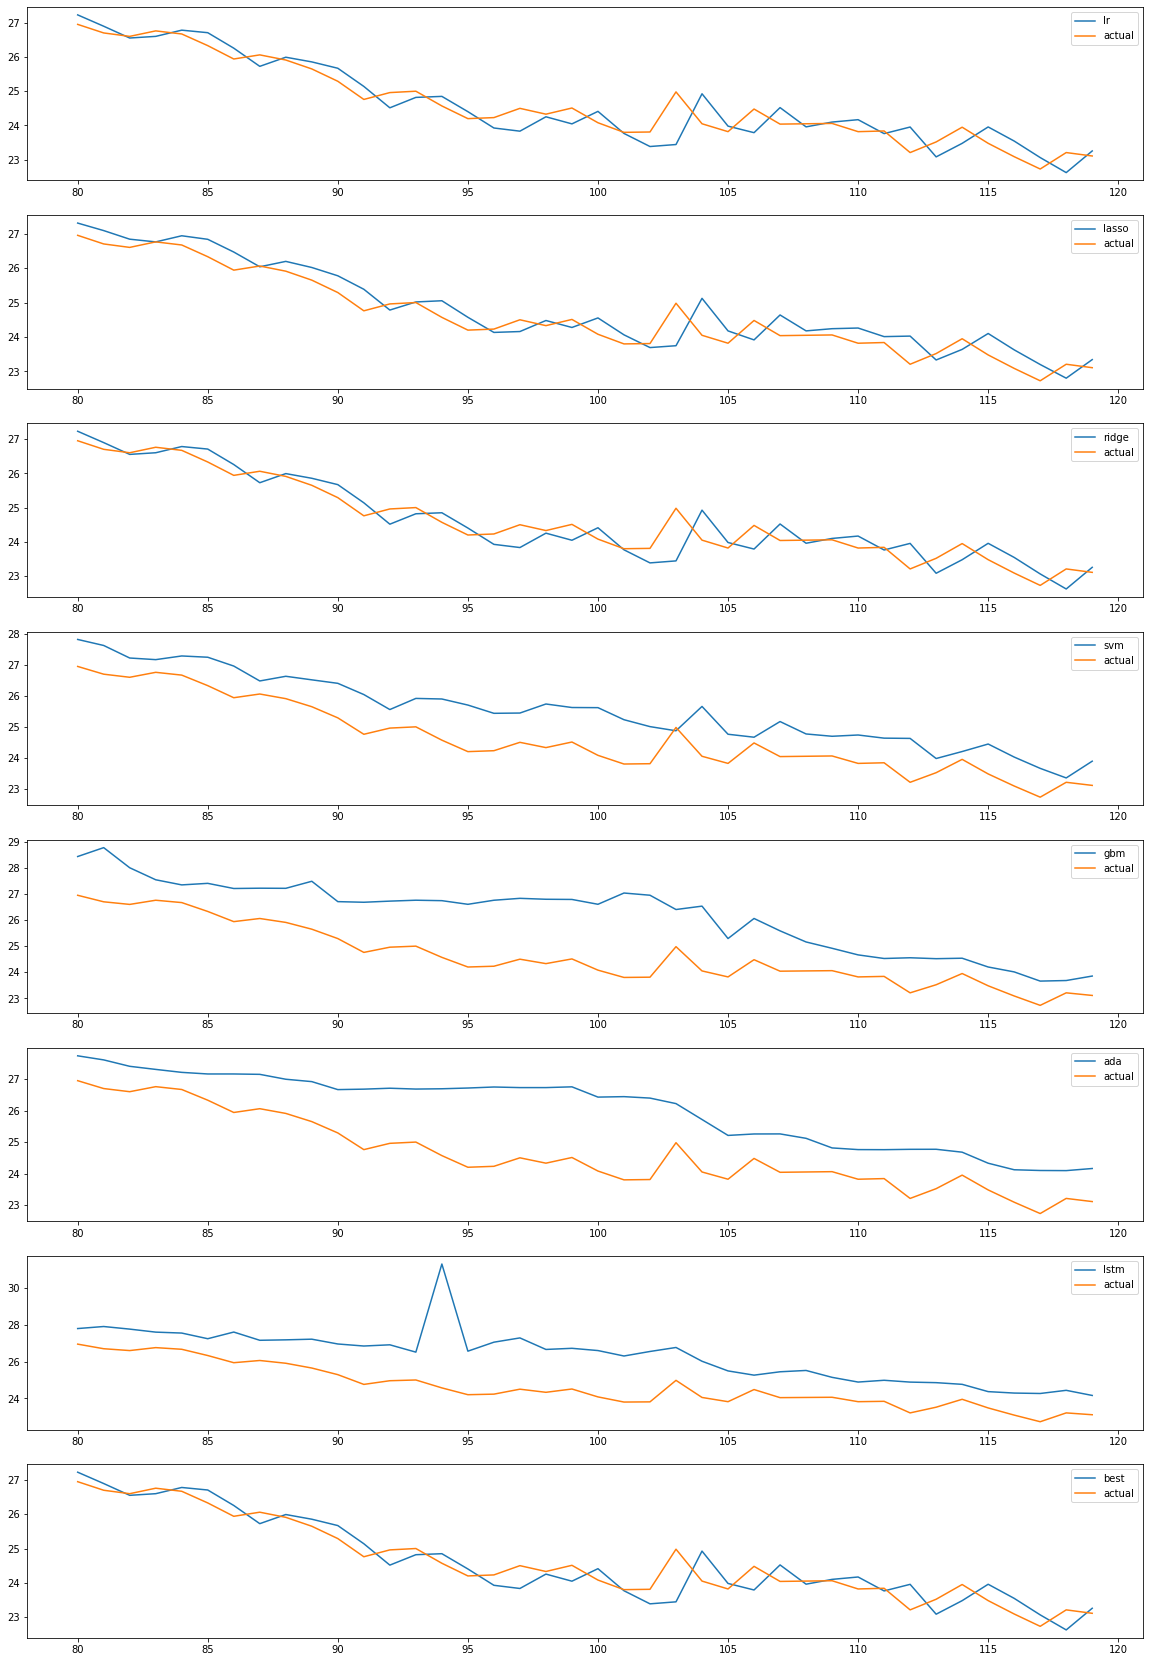

In [23]:
# plot
fig, axs = plt.subplots(8, figsize=(20,30))
ticker_index = 1 # the index of the ticker (start from 0)
x = trade_starts
axs[0].plot(x, df_predict_lr[unique_ticker[ticker_index]], label="lr")
axs[0].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[1].plot(x, df_predict_lasso[unique_ticker[ticker_index]], label="lasso")
axs[1].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[2].plot(x, df_predict_ridge[unique_ticker[ticker_index]], label="ridge")
axs[2].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[3].plot(x, df_predict_svm[unique_ticker[ticker_index]], label="svm")
axs[3].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[4].plot(x, df_predict_gbm[unique_ticker[ticker_index]], label="gbm")
axs[4].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[5].plot(x, df_predict_ada[unique_ticker[ticker_index]], label="ada")
axs[5].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[6].plot(x, df_predict_lstm[unique_ticker[ticker_index]], label="lstm")
axs[6].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[7].plot(x, df_predict_best[unique_ticker[ticker_index]], label="best")
axs[7].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
for i in range(8):
  axs[i].legend()
plt.show()

# Calculate Return
long-only strategy

In [24]:
def transform_close_to_return(df_predict_close):
  '''
  purpose: transform predicted close price to daily return
  '''
  
  df_predict_close_new = df_predict_close.copy(deep=True)

  for ticker in df_predict_close_new.columns:
    df_predict_close_new[ticker] = (df_predict_close_new[ticker] - df_predict_close_new[ticker].shift(1))/df_predict_close_new[ticker]
  
  df_predict_close_new = df_predict_close_new.dropna()
  return df_predict_close_new


def long_only_strategy(df_predict_close, actual_return, trade_starts, top_quantile_threshold=0.75):

  # transform close price to daily return
  df_predict_return = transform_close_to_return(df_predict_close) # this will drop the first row

  long_dict = {}
  for i in range(df_predict_return.shape[0]):
      top_q = df_predict_return.iloc[i].quantile(top_quantile_threshold)
      # Select Top 25% Stocks
      long_dict[df_predict_return.index[i]] = df_predict_return.iloc[i][df_predict_return.iloc[i] >= top_q]

  portfolio_return_dic = {}
  for i in range(1, len(trade_starts)): # start from 1 because the first row is dropped in "transform_close_to_return"
  
      # calculate weights based on predicted return
      min_return = min(long_dict[trade_starts[i]].values)
      long_normalize_weight = (long_dict[trade_starts[i]]-min_return) / sum(long_dict[trade_starts[i]].values - min_return)
      # map date and tic
      long_tic_return = actual_return[actual_return.index == trade_starts[i]][long_dict[trade_starts[i]].index]
      # return * weight
      long_return_table = long_tic_return * long_normalize_weight
      portfolio_return_dic[trade_starts[i]] = long_return_table.values.sum()

  df_portfolio_return = pd.DataFrame.from_dict(portfolio_return_dic, orient='index')
  df_portfolio_return = df_portfolio_return.reset_index()
  df_portfolio_return.columns = ['trade_start', 'return']
  df_portfolio_return.index = df_portfolio_return.trade_start
  df_portfolio_return = df_portfolio_return['return']
  return df_portfolio_return


In [25]:
# get the df for actual return (in percentage)
trade_start = trade_starts[1] # start from 1
trade_end = trade_starts[-1]
actual_return = pd.DataFrame(index=trade_starts[1:], columns=unique_ticker)
for ticker in unique_ticker:
   actual_return[ticker] = list(df.loc[(df.time_index>=trade_start) & (df.time_index<=trade_end) & (df.ticker==ticker)]['percentage_return(t)'])
#actual_return_2 = transform_close_to_return(df_actual)

# get return
df_portfolio_return_lr = long_only_strategy(df_predict_lr, actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_lasso = long_only_strategy(df_predict_lasso, actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_ridge = long_only_strategy(df_predict_ridge, actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_svm   = long_only_strategy(df_predict_svm,  actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_gbm   = long_only_strategy(df_predict_gbm,  actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_ada   = long_only_strategy(df_predict_ada,  actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_lstm  = long_only_strategy(df_predict_lstm, actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_best  = long_only_strategy(df_predict_best, actual_return,trade_starts,top_quantile_threshold = 0.75)


#get equally portfolio return
selected_return = actual_return[unique_ticker]
equally_portfolio_return=[]
for i in range(0, len(trade_starts)-1):
    return_remove_nan = selected_return.iloc[i][~np.isnan(actual_return.iloc[i])]
    equally_portfolio_return.append(sum(return_remove_nan)/len(return_remove_nan))
    
df_equally_portfolio_return=pd.DataFrame(equally_portfolio_return,trade_starts[1:])
df_equally_portfolio_return=df_equally_portfolio_return.reset_index()
df_equally_portfolio_return.columns= ['trade_start','return']
df_equally_portfolio_return.index=df_equally_portfolio_return.trade_start
df_equally_portfolio_return=df_equally_portfolio_return['return']

Text(0.5, 1.0, 'Cumulative Return')

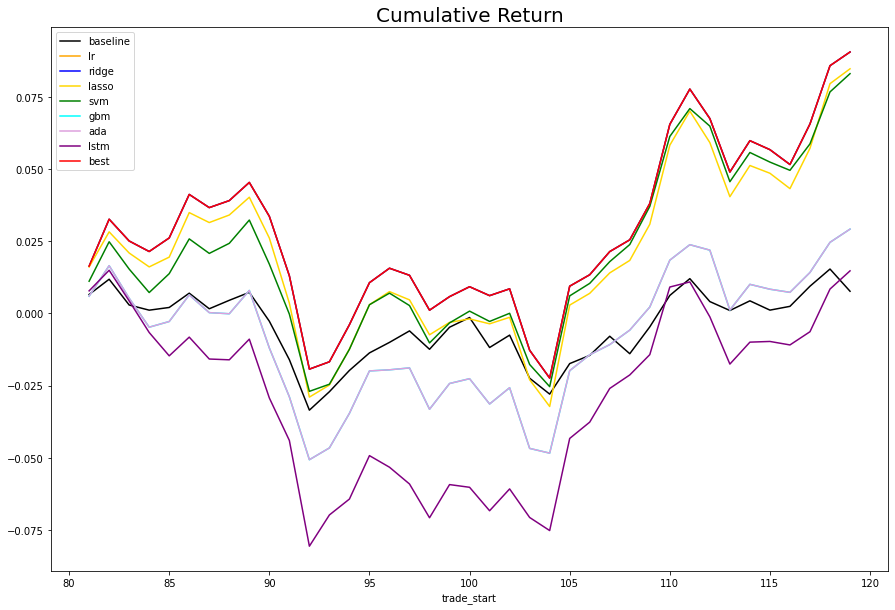

In [27]:
plt.figure(figsize=(15,10))

baseline = ((df_equally_portfolio_return+1).cumprod()-1).plot(c='black',label='baseline')

lr = ((df_portfolio_return_lr+1).cumprod()-1).plot(c='orange',label='lr')
ridge = ((df_portfolio_return_ridge+1).cumprod()-1).plot(c='b',label='ridge')
lasso = ((df_portfolio_return_lasso+1).cumprod()-1).plot(c='gold',label='lasso')
svm = ((df_portfolio_return_svm+1).cumprod()-1).plot(c='green',label='svm')
gbm = ((df_portfolio_return_ada+1).cumprod()-1).plot(c='cyan',label='gbm')
ada = ((df_portfolio_return_ada+1).cumprod()-1).plot(c='plum',label='ada')
lstm = ((df_portfolio_return_lstm+1).cumprod()-1).plot(c='purple',label='lstm')

best = ((df_portfolio_return_best+1).cumprod()-1).plot(c='r',label='best')
plt.legend()


plt.title('Cumulative Return',size=20)